In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count'

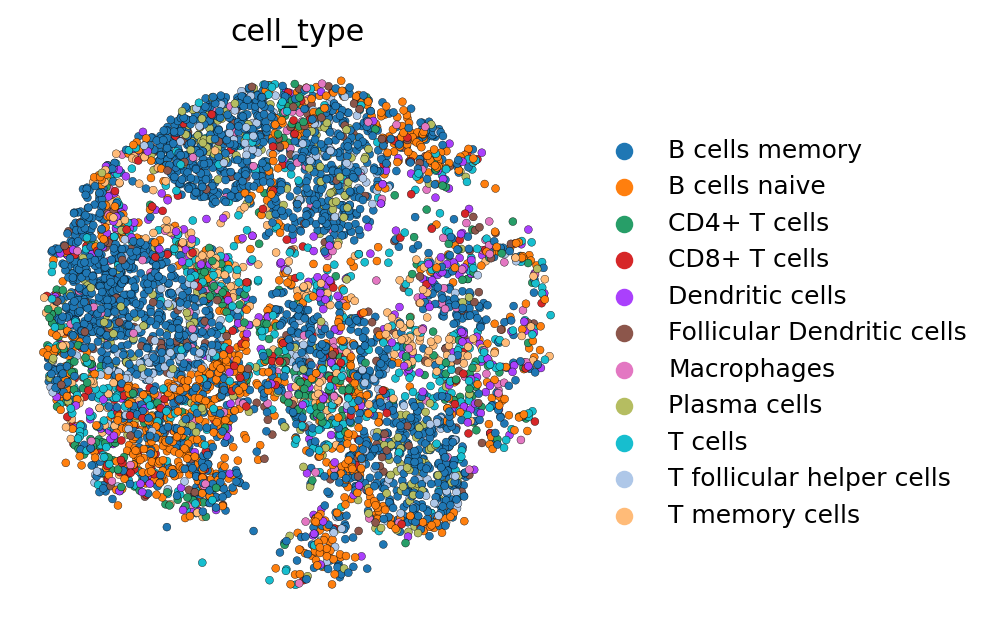

In [7]:
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180
sc.pl.embedding(adata, basis='spatial', color=['cell_type'], 
    frameon=False, edgecolor='black', s=40, linewidth=0.15)


<Axes: ylabel='cell_type'>

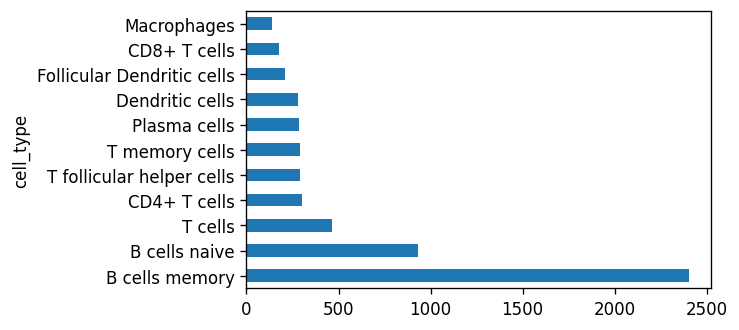

In [8]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120

adata.obs.cell_type.value_counts().plot(kind='barh')

In [9]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [10]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
# %%time

# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

In [12]:
adata.X.max()

8.8678228953803

In [13]:
adata.layers["raw_count"] = np.exp(adata.X) - 1

In [14]:
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int'
    uns: 'cell_type_colors', 'author_cell_type_colors'
    obsm: 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [16]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=7)
sc.tl.umap(adata, min_dist=0.5)

In [17]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [18]:
base_GRN = co.data.load_human_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [19]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=2
)

  0%|          | 0/11 [00:00<?, ?it/s]

Inferring GRN for B cells memory...


  0%|          | 0/3393 [00:00<?, ?it/s]

  9%|▉         | 1/11 [02:17<22:55, 137.60s/it]

Inferring GRN for B cells naive...


  0%|          | 0/3393 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [04:18<19:09, 127.67s/it]

Inferring GRN for CD4+ T cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [06:17<16:30, 123.82s/it]

Inferring GRN for CD8+ T cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [08:13<14:04, 120.66s/it]

Inferring GRN for Dendritic cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [11:32<14:53, 148.99s/it]

Inferring GRN for Follicular Dendritic cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 55%|█████▍    | 6/11 [22:59<27:39, 331.93s/it]

Inferring GRN for Macrophages...


  0%|          | 0/3393 [00:00<?, ?it/s]

 64%|██████▎   | 7/11 [34:38<30:07, 451.75s/it]

Inferring GRN for Plasma cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 73%|███████▎  | 8/11 [45:52<26:08, 522.67s/it]

Inferring GRN for T cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 82%|████████▏ | 9/11 [54:14<17:12, 516.13s/it]

Inferring GRN for T follicular helper cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

 91%|█████████ | 10/11 [56:00<06:29, 389.68s/it]

Inferring GRN for T memory cells...


  0%|          | 0/3393 [00:00<?, ?it/s]

100%|██████████| 11/11 [57:48<00:00, 315.29s/it]

CPU times: user 38min 37s, sys: 1min 44s, total: 40min 21s
Wall time: 57min 48s


In [22]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/11 [00:00<?, ?it/s]

In [23]:
import pickle

with open('/Users/koush/Desktop/training_data/snrna_human_tonsil_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)